In [1]:
from IPython.display import Image, display

# Week2-B: Four-Lights Out
In this problem, we are dealing with multiple binary data at the same time. 
We have to determine if each of the given four Lights Out boards are solvable under the given constraints, so let's devise a quantum circuit to solve them all at the same time.

As an example, let's consider how to find a board that can be cleared with just a single switch operation from the 4 boards given below. The initial state of the 4 boards is given in the following two-dimensional array, where "0" and "1" represent "off" and "on" respectively similar to the previous learning problem:

lightsout4_ex=\[\[Board 0\],\[Board 1\],\[Board 2\],\[Board 3\]\]

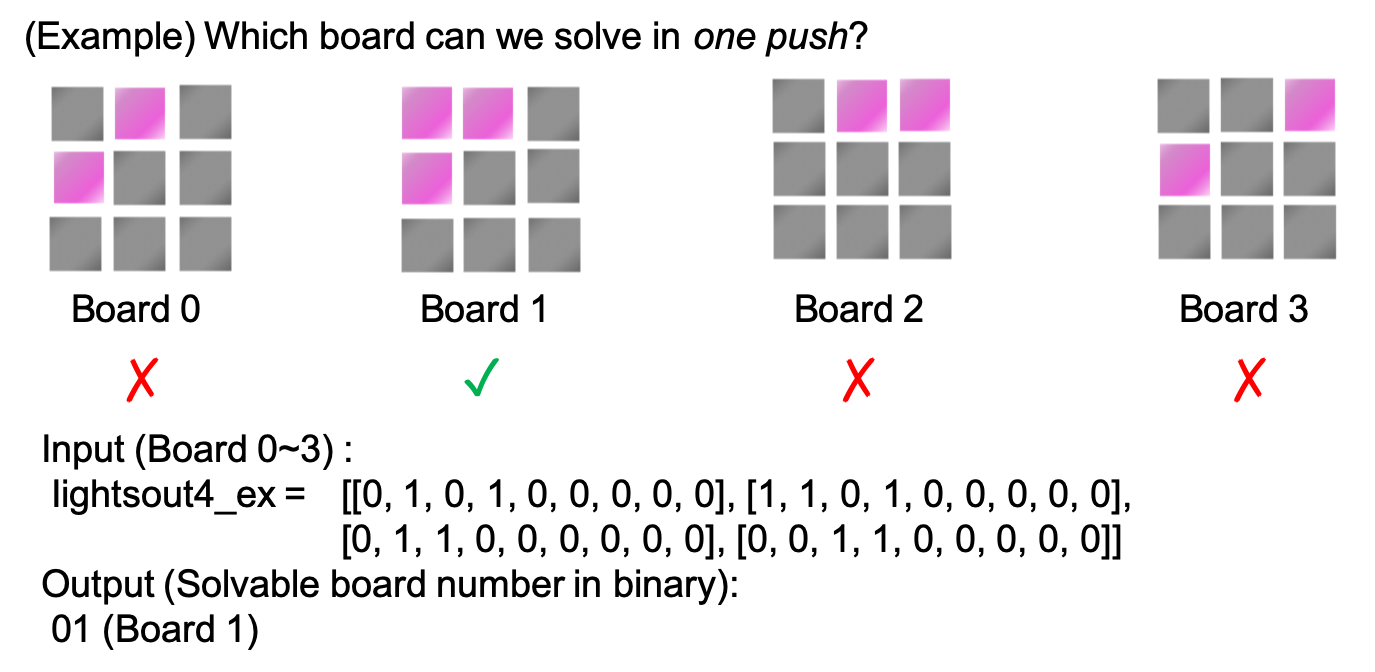

In [2]:
from IPython.display import Image, display
Image('img/4lightsout_ex.png')

## Answer Strategy
If only one board is given, this is a decision problem.
Using the algorithm from the first Lights Out puzzle (2A), you can solve this problem by counting the "1"s in the output.
 
If we are given multiple boards, there will be several approaches.
1. Iterate the same "one board algorithm" for each board.
2. Hold information for multiple boards at the same time and solve the problems in a single run (execute the algorithm once). 
- For the rest of this document, we discuss how to use the latter approach to solve this type of problem.

First, how do we keep data for all the boards at the same time?
1. Naive data structures:　　9 Qubits/board * 4 boards > 32 qubits (Upper limit of ibm_qasm_simulator).
2. Prepare the  superposition state:   $\vert Board 0\rangle + \vert Board 1\rangle + \vert Board 2\rangle + \vert Board 3\rangle$.
    - The circuit configuration used for state generation is non-trivial.
3. *qRAM* is known as one solution. 
    - **Pros**: Intuitive implementation. 
    - **Cons**: Computationally expensive. 

Of course you can devise and adopt other smart ways to do this.

Here, we will focus on *qRAM* and describe its configuration and implementation.

In [3]:
from qiskit import *
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit
from qiskit import IBMQ, Aer, execute
provider = IBMQ.load_account()

c:\users\ana\appdata\local\programs\python\python36\lib\site-packages\qiskit\providers\ibmq\ibmqfactory.py:192: UserWarning: Timestamps in IBMQ backend properties, jobs, and job results are all now in local time instead of UTC.
  warnings.warn('Timestamps in IBMQ backend properties, jobs, and job results '


## qRAM: Quantum Random Access Memory

In classical computers, RAM (Random Access Memory) is a type of volatile memory that has memory addresses $j$ and stores binary data corresponding to each address $D_j$.

In the case of [qRAM](https://arxiv.org/abs/0708.1879) in a quantum computer, **address qubits $a$** have the $N$-addresses as superposition and the corresponding binary data is stored in **data qubits $d$** as a state vector.
\\[
\sum_{j}\frac{1}{\sqrt{N}}\vert j \rangle_{a}\vert 0 \rangle_{d}\xrightarrow{qRAM}\sum_{j}\frac{1}{\sqrt{N}}\vert j \rangle_{a}\vert D_{j} \rangle_{d}
\\]　　
We call the right-hand side state "qRAM" and the corresponding gate operation "qRAM operation".

Although qRAM operation requires $\mathcal{O}(N\log N)$ gates, it can be used to create superposition states of binary data intuitively.  

qRAM has previously been applied to various quantum machine learning algorithms such as the HHL algorithm. For this problem, let's apply qRAM to Grover's algorithm.

## Example: Find the data from qRAM
Prepare a qRAM of $n$-addresses in which the numbers $k_0, k_1, .. , k_{n-1}$ are stored in this order.  
Find the address in which the number $m$ is stored using Grover's algorithm.  
- $n = 4$
- $k = [1,2,5,7]$
- $m = 7$

### qRAM operation.
Here we show a circuit example of qRAM.

c:\users\ana\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:41: DeprecationWarning: Using `backend_options` kwarg has been deprecated as of qiskit-aer 0.7.0 and will be removed no earlier than 3 months from that release date. Runtime backend options should now be added directly using kwargs for each option.


{'00001': 2008, '10101': 2039, '11111': 1964, '01010': 1989}


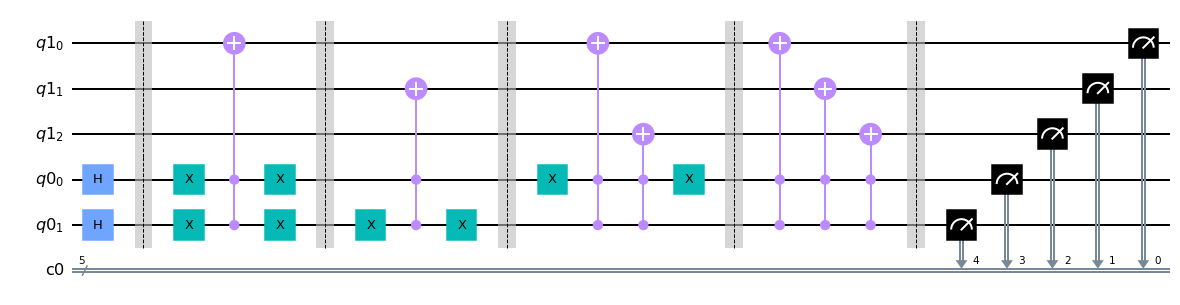

In [4]:
address = QuantumRegister(2)
data = QuantumRegister(3)
c = ClassicalRegister(5)
qc = QuantumCircuit(address,data,c)

# address preparation
qc.h([address[0],address[1]])
qc.barrier()
# address 0 -> data = 1
qc.x([address[0],address[1]])
qc.ccx(address[0],address[1],data[2])
qc.x([address[0],address[1]])
qc.barrier()
# address 1 -> data = 2
qc.x(address[0])
qc.ccx(address[0],address[1],data[1])
qc.x(address[0])
qc.barrier()
# address 2 -> data = 5
qc.x(address[1])
qc.ccx(address[0],address[1],data[2])
qc.ccx(address[0],address[1],data[0])
qc.x(address[1])
qc.barrier()
# address 3 -> data = 7
qc.ccx(address[0],address[1],data[2])
qc.ccx(address[0],address[1],data[1])
qc.ccx(address[0],address[1],data[0])
qc.barrier()


#Check the qRAM　status
qc.measure(address[0:2], c[0:2])
qc.measure(data[0:3], c[2:5])
 
# Reverse the output string.
qc = qc.reverse_bits()

#backend = provider.get_backend('ibmq_qasm_simulator')
backend = Aer.get_backend('qasm_simulator')
job = execute(qc, backend=backend, shots=8000, seed_simulator=12345, backend_options={"fusion_enable":True})
#job = execute(qc, backend=backend, shots=8192)
result = job.result()
count =result.get_counts()
print(count)

qc.draw(output='mpl')

### qRAM Data Search
To perform Grover's algorithm, we invert the sign of the **address qubit** containing $m$. We also need to initialize the **data qubit** by another qRAM operation before the Diffusion operation,

\begin{align*}
\vert j \rangle_{a}\vert D_{j} \rangle_{d} \vert - \rangle_{f}
\xrightarrow{oracle}  
\left \{
 \begin{array}{l}
-\vert j \rangle_{a}\vert D_{j} \rangle_{d} \vert - \rangle_{f},  D_{j} = m\\
\vert j \rangle_{a}\vert D_{j} \rangle_{d} \vert - \rangle_{f},  D_{j}  \neq m
 \end{array}
 \right.
 \xrightarrow{qRAM}
\left \{
 \begin{array}{l}
-\vert j \rangle_{a}\vert 0 \rangle_{d}\vert - \rangle_{f},  D_{j} = m \\
\vert j \rangle_{a}\vert 0 \rangle_{d}\vert - \rangle_{f},　D_{j}\neq m
 \end{array}
 \right.
 \end{align*}
 
where $f$ denotes the flag qubit.  

In this case, we can configure an oracle operation using the [C3X gate](https://qiskit.org/documentation/stubs/qiskit.circuit.library.C3XGate.html#qiskit.circuit.library.C3XGate) . 

Here, we show the whole circuit for our [qRAM example](#qRAM-Example:-Find-the-data-from-qRAM).

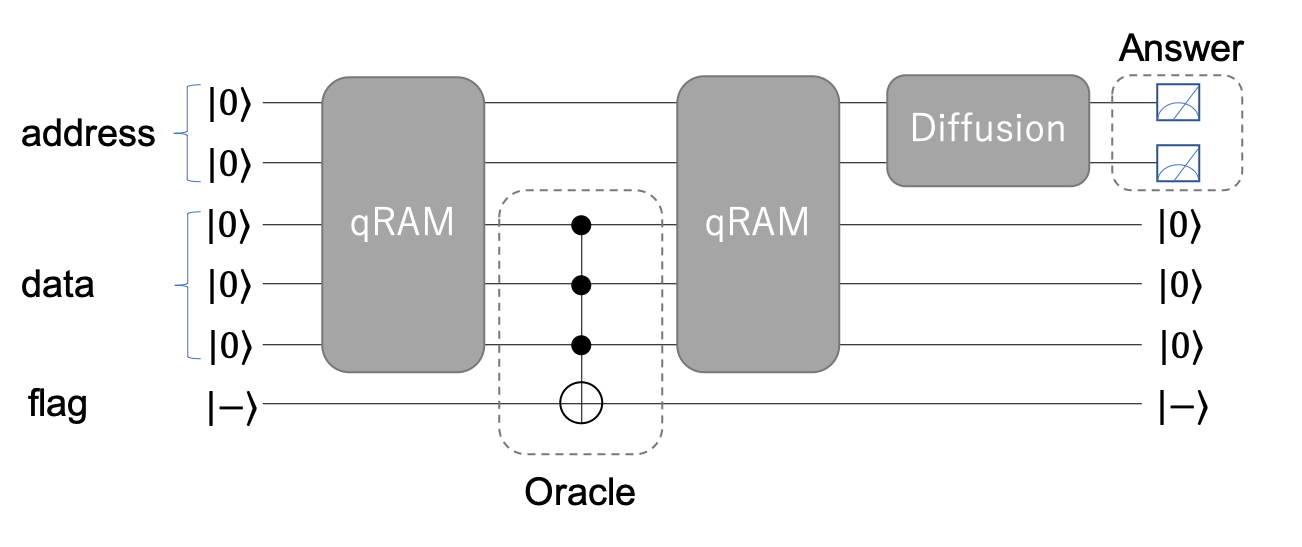

In [5]:
Image('img/circuit_ex.png')

### Considerations for qRAM implementation
In the above description we have introduced a naive *qRAM operation* circuit.
Depending on the data structure, we can simplify the circuit by using **gate synthesis** (equivalence transformation) techniques.
Also, some simplified gates, e.g. [RCCX](https://qiskit.org/documentation/stubs/qiskit.circuit.library.RCCXGate.html#qiskit.circuit.library.RCCXGate), may help improve your *CNOT*-saving implementation.

An example of gate synthesis is shown below.

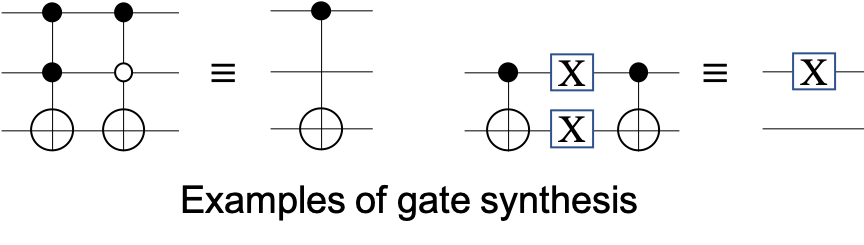

In [6]:
Image('img/gatesynthesis_ex.png')

## Learning Exercise II-B
Let's solve a 4-Lights Out problem with qRAM.  

When the initial board state lightsout4=\[\[Board 0\],\[Board 1\],\[Board 2\],\[Board 3\]\] is described by the following data, 
determine the _binary_ number of the solvable boards in $3$ switch operations.  (ex. Board 0 → 00, 1 → 01, 2 → 10, 3 → 11)

Answer by creating a quantum circuit to solve the puzzle shown in the figure below. In the quantum circuit to be submitted, measure only the `solution` (2bit) that solves the puzzle.

To submit your solution, create a function which takes "lightsout4" as an input and returns `QuantumCircuit`.  You can choose a function name you like. Make sure it works even if you input another dataset to "lightsout4".

 **In addition, please implement the quantum circuit within 28 qubits.**

Please note that you can get the answer with the same endian as the one used in the description. You can also use the following function.
```python
qc = qc.reverse_bits()
```

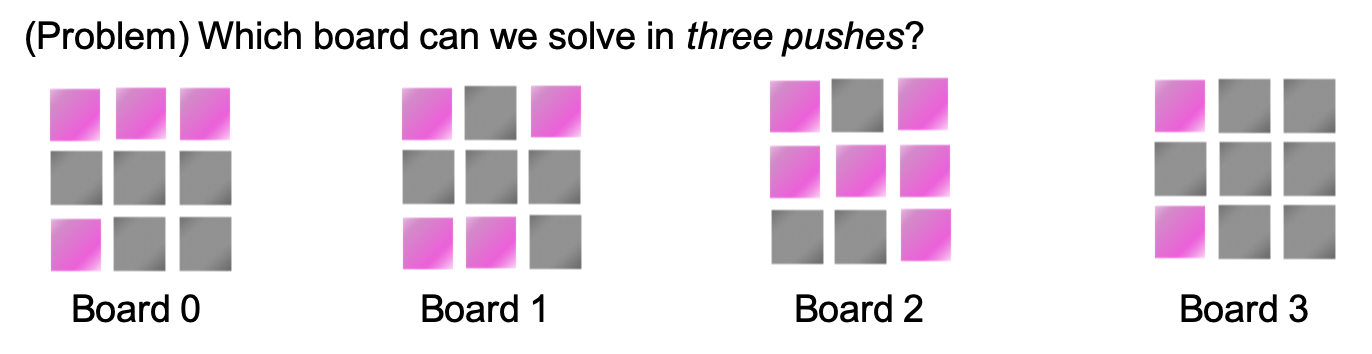

In [7]:
Image('img/4lightsout_pr.png')

In [34]:
lightsout4=[[1,1,1, 0,1,1, 0,0,1],[1,1,0, 0,0,1, 1,1,1],[1,1,0, 1,1,1, 0,1,1],[1,1,0, 0,0,1, 1,1,0]]

### Hints
- Change the oracle of [qRAM data search](#qRAM-Data-search) to an appropriate one.
- Data storing/writing in *QRAM operation* can be performed in any order. We can reduce the number of gates by taking into account the _hamming distance_ of the address and input data.

In [9]:
# Initialization
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

# Importing Qiskit
from qiskit import BasicAer
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, execute

# Import basic plot tools
from qiskit.tools.visualization import plot_histogram

In [10]:
from qiskit import IBMQ
provider = IBMQ.load_account()
backend = provider.get_backend('ibmq_qasm_simulator')

c:\users\ana\appdata\local\programs\python\python36\lib\site-packages\qiskit\providers\ibmq\ibmqfactory.py:192: UserWarning: Timestamps in IBMQ backend properties, jobs, and job results are all now in local time instead of UTC.
  warnings.warn('Timestamps in IBMQ backend properties, jobs, and job results '
ibmqfactory.load_account:WARNING:2021-02-14 15:13:03,074: Credentials are already in use. The existing account in the session will be replaced.


In [35]:
indices = [[i for i, x in enumerate(lights) if x == 1] for lights in lightsout4 ]

In [36]:
indices

[[0, 1, 2, 4, 5, 8],
 [0, 1, 5, 6, 7, 8],
 [0, 1, 3, 4, 5, 7, 8],
 [0, 1, 5, 6, 7]]

In [23]:
def qram(qc,indices,address,board):
    # address 0 -> board = 0
    qc.x([address[0],address[1]])
    for j in range(0,len(indices[0])):
        qc.ccx(address[0],address[1],board[indices[0][j]])
    qc.x([address[0],address[1]])
    qc.barrier()
    
    # address 1 -> board = 1
    qc.x(address[1])
    for j in range(0,len(indices[1])):
        qc.ccx(address[0],address[1],board[indices[1][j]])
    qc.x(address[1])
    qc.barrier()
    
    # address 2 -> board = 2
    qc.x(address[0])
    for j in range(0,len(indices[2])):
        qc.ccx(address[0],address[1],board[indices[2][j]])
    qc.x(address[0])
    qc.barrier()
    
    # address 3 -> board = 3
    for j in range(0,len(indices[3])):
        qc.ccx(address[0],address[1],board[indices[3][j]])
    qc.barrier()

In [24]:
def switch_flip(qc,solution,board):
    #press 0
    qc.cx(solution[0],board[0])
    qc.cx(solution[0],board[1])
    qc.cx(solution[0],board[3])

    #press 1
    qc.cx(solution[1],board[0])
    qc.cx(solution[1],board[1])
    qc.cx(solution[1],board[2])
    qc.cx(solution[1],board[4])

    #press 2
    qc.cx(solution[2],board[1])
    qc.cx(solution[2],board[2])
    qc.cx(solution[2],board[5])

    #press 3
    qc.cx(solution[3],board[0])
    qc.cx(solution[3],board[3])
    qc.cx(solution[3],board[4])
    qc.cx(solution[3],board[6])

    #press 4
    qc.cx(solution[4],board[1])
    qc.cx(solution[4],board[3])
    qc.cx(solution[4],board[4])
    qc.cx(solution[4],board[5])
    qc.cx(solution[4],board[7])

    #press 5
    qc.cx(solution[5],board[2])
    qc.cx(solution[5],board[4])
    qc.cx(solution[5],board[5])
    qc.cx(solution[5],board[8])

    #press 6
    qc.cx(solution[6],board[3])
    qc.cx(solution[6],board[6])
    qc.cx(solution[6],board[7])

    #press 7
    qc.cx(solution[7],board[4])
    qc.cx(solution[7],board[6])
    qc.cx(solution[7],board[7])
    qc.cx(solution[7],board[8])

    #press 8
    qc.cx(solution[8],board[5])
    qc.cx(solution[8],board[7])
    qc.cx(solution[8],board[8])

In [25]:
def counter(qc,solution,auxiliary):
    for i in range(len(solution)):
        qc.mct([solution[i],auxiliary[0],auxiliary[1],auxiliary[2]],auxiliary[3],auxiliary[4:6])
        qc.mct([solution[i],auxiliary[0],auxiliary[1]],auxiliary[2],auxiliary[4])
        qc.ccx(solution[i],auxiliary[0],auxiliary[1])
        qc.cx(solution[i],auxiliary[0])
        
def revcounter(qc, solution,auxiliary):
    for i in range(len(solution)):
        qc.cx(solution[i],auxiliary[0])
        qc.ccx(solution[i],auxiliary[0],auxiliary[1])
        qc.mct([solution[i],auxiliary[0],auxiliary[1]],auxiliary[2],auxiliary[4])
        qc.mct([solution[i],auxiliary[0],auxiliary[1],auxiliary[2]],auxiliary[3],auxiliary[4:6])

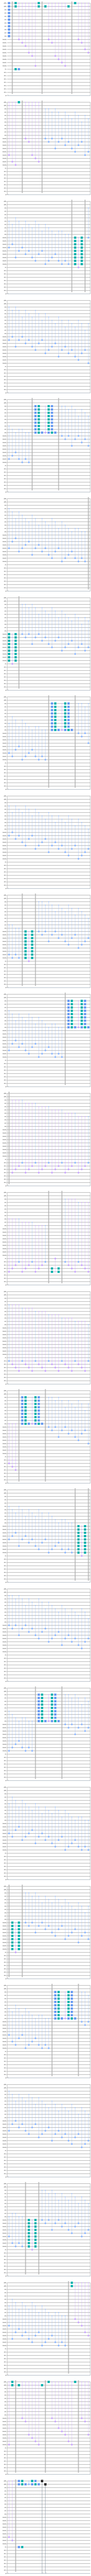

In [37]:
indices = [[i for i, x in enumerate(lights) if x == 1] for lights in lightsout4 ]

address = QuantumRegister(2)
solution = QuantumRegister(9,'sol')
board = QuantumRegister(9,'board')
oracle = QuantumRegister(1,'or')
ancilla = QuantumRegister(7,'anc')
cr = ClassicalRegister(2)

qc = QuantumCircuit(address,solution,board,oracle,ancilla, cr)

# address and oracle preparation
qc.h([address[0],address[1]])
qc.h(solution[:])
qc.barrier()
qc.x(oracle[0])
qc.h(oracle[0])

qram(qc,indices,address,board)

for i in range(3):

    #solving lights out

    switch_flip(qc,solution,board)

    qc.barrier()

    #board solution oracle
    qc.x(board[:])
    qc.mct(board[:], oracle[0])
    qc.x(board[:])
    
    qc.barrier()
    
    switch_flip(qc,solution,board)
    
    qc.barrier()
    
    #solution diffusion
    qc.h(solution[:])
    qc.x(solution[:])
    qc.h(solution[8])
    qc.mct(solution[0:8], solution[8])
    qc.h(solution[8])
    qc.x(solution[:])
    qc.h(solution[:])
    
    qc.barrier()

    
counter(qc,solution,ancilla)

qc.barrier()

#counter oracle
qc.x(ancilla[2])
qc.x(ancilla[3])
qc.ccx(ancilla[2],ancilla[3],oracle[0])
qc.x(ancilla[2])
qc.x(ancilla[3])
    
qc.barrier()

revcounter(qc,solution,ancilla)

qc.barrier()


#uncompution
for i in range(3):

    #solution diffusion
    qc.h(solution[:])
    qc.x(solution[:])
    qc.h(solution[8])
    qc.mct(solution[0:8], solution[8])
    qc.h(solution[8])
    qc.x(solution[:])
    qc.h(solution[:])
    
    qc.barrier()
    
    switch_flip(qc,solution,board)

    qc.barrier()

    #board solution oracle
    qc.x(board[:])
    qc.mct(board[:], oracle[0])
    qc.x(board[:])
    
    qc.barrier()
    
    switch_flip(qc,solution,board)
    
    qc.barrier()
    

qram(qc,indices,address,board)

#address diffusion
qc.h(address[:])
qc.x(address[:])
qc.h(address[1])
qc.cx(address[0], address[1])
qc.h(address[1])
qc.x(address[:])
qc.h(address[:])
    

qc.h(oracle[0])
qc.x(oracle[0])

qc.measure(address[0],cr[0])
qc.measure(address[1],cr[1])
#qc=qc.reverse_bits()


qc.draw(output='mpl')

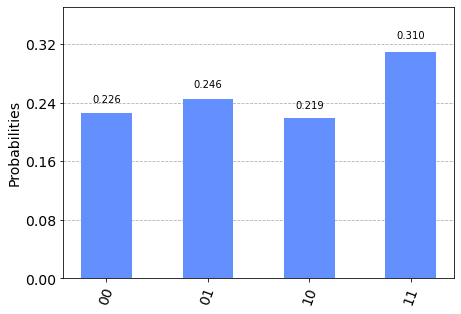

In [39]:
shots = 3000
results = execute(qc, backend=backend, shots=shots).result()
answer = results.get_counts()
plot_histogram(answer)